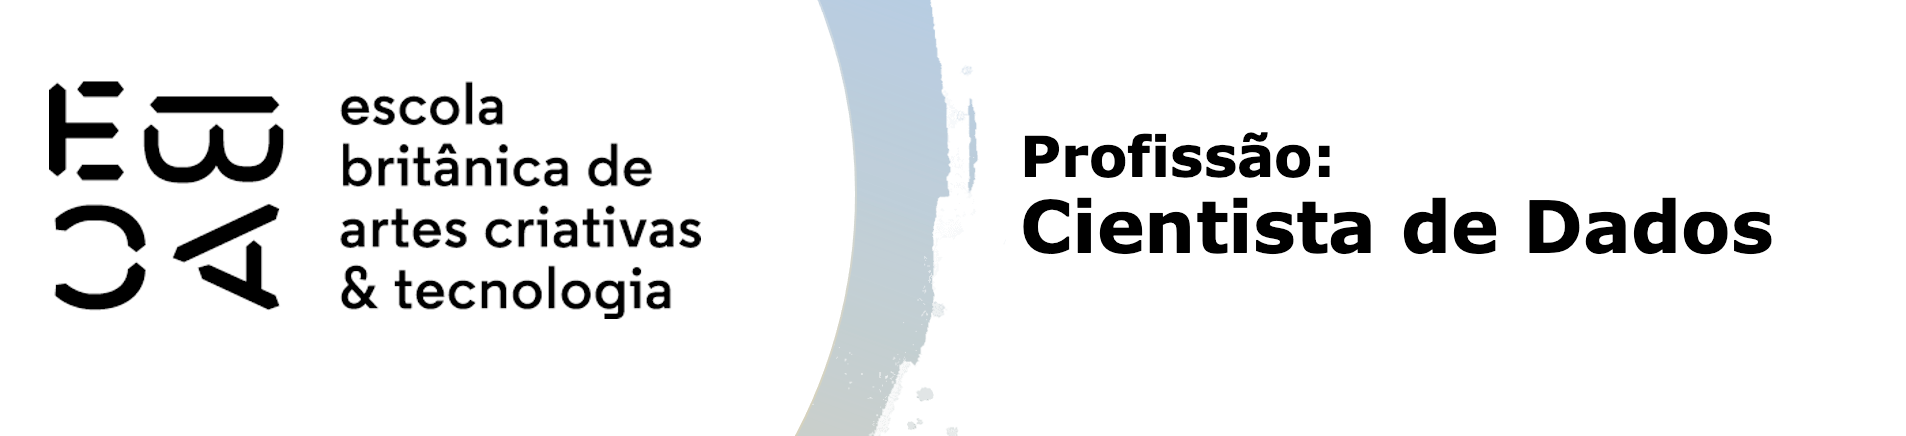

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate         import interp1d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats



In [107]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)

df.info()

df

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 2015-01-01 to 2016-03-01
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  750000 non-null  int64  
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          624240 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 80.1+ MB


,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-01,11611,F,N,S,1,Assalariado,Superior completo,Casado,Casa,29,8.665753,3.0,2930.40
2016-03-01,9144,F,N,S,0,Pensionista,Superior completo,Casado,Casa,65,NaN,2.0,4084.37
2016-03-01,16583,F,N,S,0,Assalariado,Superior completo,Casado,Casa,33,10.969863,2.0,4339.66


In [108]:
# Eliminando a coluna index devido sua irrelevancia
df.drop(columns=["index"], inplace=True)

# Substituindo valores ausentes para cada variável no DataFrame pela media dos valores
df['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace=True)
df.isna().sum()

# Adicionando uma nova coluna 'renda_log' com o logaritmo natural dos valores da coluna 'renda'
df['renda_log'] = np.log(df['renda'])

# Convertendo o índice do DataFrame para o tipo datetime
df.index = pd.to_datetime(df.index)

# Imprimindo os meses presentes na base de dados
print(f'''Meses presentes na base:
{[mes for mes in df.index.unique().strftime('%b%y')]}

Três últimos meses na base:
{[mes for mes in df[df.index > (df.index.unique().max() - pd.DateOffset(months=3))].index.unique().strftime('%b%y')]}
''')

Meses presentes na base:
['Jan15', 'Feb15', 'Mar15', 'Apr15', 'May15', 'Jun15', 'Jul15', 'Aug15', 'Sep15', 'Oct15', 'Nov15', 'Dec15', 'Jan16', 'Feb16', 'Mar16']

Três últimos meses na base:
['Jan16', 'Feb16', 'Mar16']



In [109]:
# Criando um DataFrame de holdout (df_holdout) contendo apenas os dados dos últimos três meses da base de dados original
df_holdout = df[df.index > (df.index.unique().max() - pd.DateOffset(months=3))].copy()

# Imprimindo os meses presentes na base de holdout (df_holdout)
print(f'''Base holdout (df_holdout):
{[mes for mes in df_holdout.index.unique().strftime('%b%y')]}
''')

# Exibindo o DataFrame de holdout
df = df_holdout
df

Base holdout (df_holdout):
['Jan16', 'Feb16', 'Mar16']



,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log
data_ref,,,,,,,,,,,,,
2016-01-01,F,N,S,0,Pensionista,Médio,Casado,Casa,61,7.746165,2.0,2137.61,7.667444
2016-01-01,F,N,S,2,Servidor público,Superior completo,Casado,Casa,27,9.301370,4.0,13884.35,9.538518
2016-01-01,F,S,S,3,Assalariado,Médio,Casado,Casa,38,10.967123,5.0,11042.47,9.309504
2016-01-01,M,S,S,3,Servidor público,Médio,Casado,Casa,35,5.553425,5.0,1333.82,7.195802
2016-01-01,F,S,N,0,Assalariado,Médio,Viúvo,Casa,63,9.265753,1.0,17633.03,9.777529
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-01,F,N,S,1,Assalariado,Superior completo,Casado,Casa,29,8.665753,3.0,2930.40,7.982894
2016-03-01,F,N,S,0,Pensionista,Superior completo,Casado,Casa,65,7.746165,2.0,4084.37,8.314923
2016-03-01,F,N,S,0,Assalariado,Superior completo,Casado,Casa,33,10.969863,2.0,4339.66,8.375551


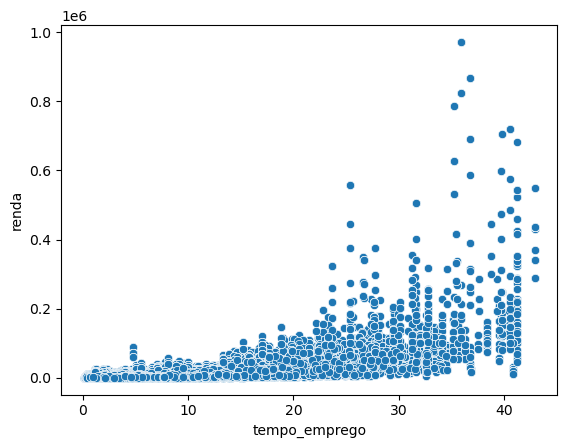

In [110]:
sns.scatterplot(y='renda', x = 'tempo_emprego', data=df);

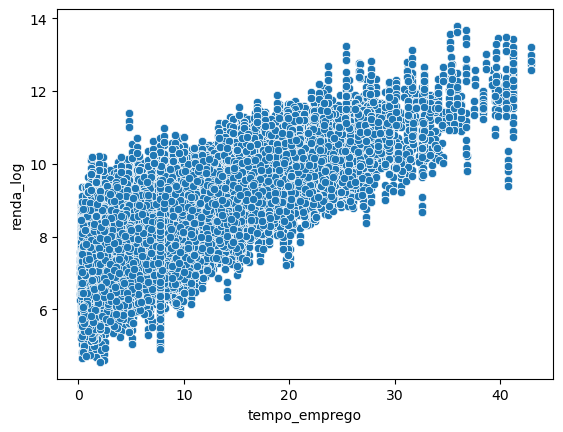

In [111]:
sns.scatterplot(y='renda_log', x = 'tempo_emprego', data=df);

In [112]:
# Regressão simples da renda pela variavel 'tempo_emprego'
reg = smf.ols('renda ~ tempo_emprego', data=df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                 6.604e+04
Date:                Sat, 10 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:46:13   Log-Likelihood:            -1.6985e+06
No. Observations:              150000   AIC:                         3.397e+06
Df Residuals:                  149998   BIC:                         3.397e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -9313.1077     83.602   -111.398      0.000   -9476.967   -9149.249
tempo_emprego  2178.8028      8.478    256.991      0.000    2162.186    2195.420
==============================================================================
Omnibus:                   308752.272   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1599323504.132
Skew:                          17.350   Prob(JB):                         0.00
Kurtosis:                     507.666   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
# Regressão simples agora usnado a variavel 'renda_log' 
reg = smf.ols('renda_log ~ tempo_emprego', data=df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                 1.635e+05
Date:                Sat, 10 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:46:15   Log-Likelihood:            -1.7066e+05
No. Observations:              150000   AIC:                         3.413e+05
Df Residuals:                  149998   BIC:                         3.413e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.0989      0.003   2252.228      0.000       7.093       7.105
tempo_emprego     0.1293      0.000    404.381      0.000       0.129       0.130
==============================================================================
Omnibus:                       13.139   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.567
Skew:                           0.008   Prob(JB):                      0.00113
Kurtosis:                       3.043   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

c:\Users\Xam_j\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


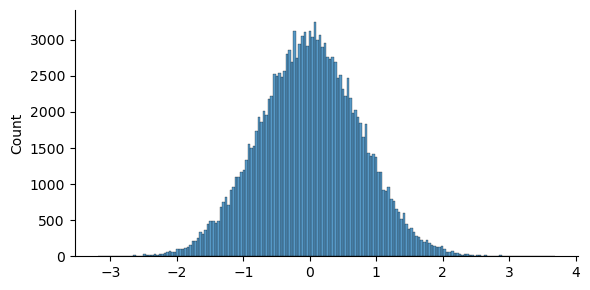

In [114]:
# Verificando se os dados tem distribuição normal 
sns.displot(reg.resid, height=3, aspect=2);

In [115]:
# tornando as variaveis categoricas em dummies
variaveis_categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
df_dummies = pd.get_dummies(df, columns=variaveis_categoricas, drop_first=True)
df = df_dummies
df_ = df


In [116]:
# Verificar a correlação entre as variaveis
correlation_matrix = df.corr()
correlation_matrix

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
qtd_filhos,1.000000,-0.370326,-0.068657,0.890791,-0.043940,-0.026554,0.112412,0.112919,-0.015737,-0.012870,...,0.027579,-0.021718,-0.129207,0.000073,-0.101463,-0.030939,0.037687,-0.003063,0.027985,-0.003623
idade,-0.370326,1.000000,0.249443,-0.341295,0.114009,0.136935,-0.213304,-0.166611,0.133370,0.014054,...,-0.150051,0.053828,-0.067053,-0.059812,0.226568,0.157411,-0.187103,-0.018322,-0.007071,0.005880
tempo_emprego,-0.068657,0.249443,1.000000,-0.060649,0.552902,0.722199,-0.129478,-0.071717,0.007312,0.010588,...,-0.042129,0.016265,-0.014007,-0.018325,0.024637,0.049965,-0.071981,-0.024854,0.017406,0.021367
qt_pessoas_residencia,0.890791,-0.341295,-0.060649,1.000000,-0.052157,-0.021215,0.148956,0.160597,-0.017965,-0.005162,...,0.017781,-0.227975,-0.425533,0.070726,-0.262238,-0.017086,0.027796,-0.000788,0.023474,-0.006413
renda,-0.043940,0.114009,0.552902,-0.052157,1.000000,0.564182,-0.082008,-0.043580,0.032214,-0.002301,...,-0.006162,0.013921,0.037428,-0.011212,-0.003573,0.024901,-0.029931,-0.008235,0.010657,0.000031
renda_log,-0.026554,0.136935,0.722199,-0.021215,0.564182,1.000000,-0.031599,-0.015444,0.075336,0.002813,...,-0.029579,0.016625,-0.008663,-0.014499,-0.005117,0.039492,-0.051458,-0.020564,0.013661,0.004199
sexo_M,0.112412,-0.213304,-0.129478,0.148956,-0.082008,-0.031599,1.000000,0.367579,-0.055747,-0.015347,...,0.022930,-0.059065,-0.033838,-0.027072,-0.138566,-0.063991,0.053764,0.020370,0.055382,-0.020429
posse_de_veiculo_S,0.112919,-0.166611,-0.071717,0.160597,-0.043580,-0.015444,0.367579,1.000000,-0.028143,-0.017532,...,0.021351,-0.075046,-0.081717,-0.037343,-0.090033,-0.023539,0.021904,0.031580,0.030696,-0.017795
posse_de_imovel_S,-0.015737,0.133370,0.007312,-0.017965,0.032214,0.075336,-0.055747,-0.028143,1.000000,0.015365,...,-0.045247,-0.020400,0.004712,-0.032112,0.040470,0.203133,-0.156978,-0.022864,-0.039796,-0.120090
tipo_renda_Bolsista,-0.012870,0.014054,0.010588,-0.005162,-0.002301,0.002813,-0.015347,-0.017532,0.015365,1.000000,...,-0.004417,-0.005355,-0.008224,-0.006374,-0.004567,0.007358,-0.004721,-0.001454,-0.001862,-0.003923


In [117]:
# Dividir o DataFrame em Variáveis Independentes
X = df.drop(columns=['renda_log'])
y = df['renda_log']

In [118]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicialize o modelo
model = LinearRegression()

# Treine o modelo
model.fit(X_train, y_train)

# Faça previsões
y_pred = model.predict(X_test)

# Avalie o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Erro Quadrático Médio (MSE): {mse}')
print(f'Coeficiente de Determinação (R²): {round(r2, 3)*100}%')


Erro Quadrático Médio (MSE): 0.4965171623082593
Coeficiente de Determinação (R²): 58.4%


In [119]:
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)


                               Coefficient
qtd_filhos                       -0.167483
idade                             0.003297
tempo_emprego                     0.107660
qt_pessoas_residencia             0.177118
renda                             0.000010
sexo_M                            0.141112
posse_de_veiculo_S                0.009641
posse_de_imovel_S                 0.169118
tipo_renda_Bolsista              -0.319456
tipo_renda_Empresário             0.140942
tipo_renda_Pensionista           -0.240078
tipo_renda_Servidor público       0.129065
educacao_Médio                    0.020506
educacao_Pós graduação            0.124848
educacao_Superior completo        0.110478
educacao_Superior incompleto      0.032890
estado_civil_Separado             0.203091
estado_civil_Solteiro             0.152779
estado_civil_União                0.012854
estado_civil_Viúvo                0.200622
tipo_residencia_Casa             -0.058630
tipo_residencia_Com os pais      -0.036626
tipo_reside

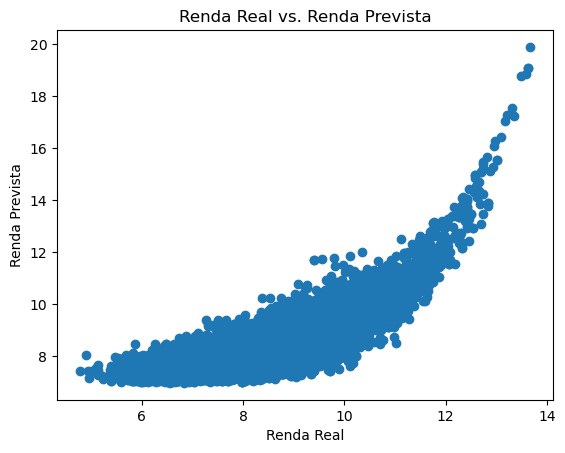

In [120]:
plt.scatter(y_test, y_pred)
plt.xlabel("Renda Real")
plt.ylabel("Renda Prevista")
plt.title("Renda Real vs. Renda Prevista")
plt.show()


## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

c:\Users\Xam_j\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


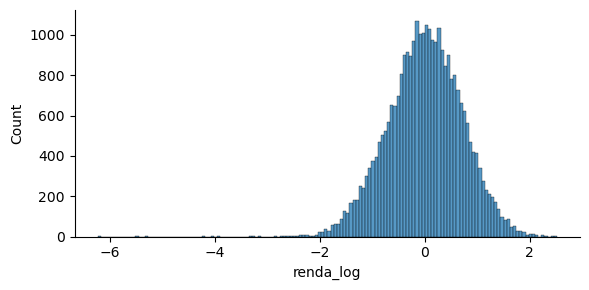

In [121]:
# Verificando se os dados tem distribuição normal 
# Calcular os resíduos
residuals = y_test - y_pred

# Verificando se os dados tem distribuição normal Histograma dos resíduos
sns.displot(residuals, height=3, aspect=2);

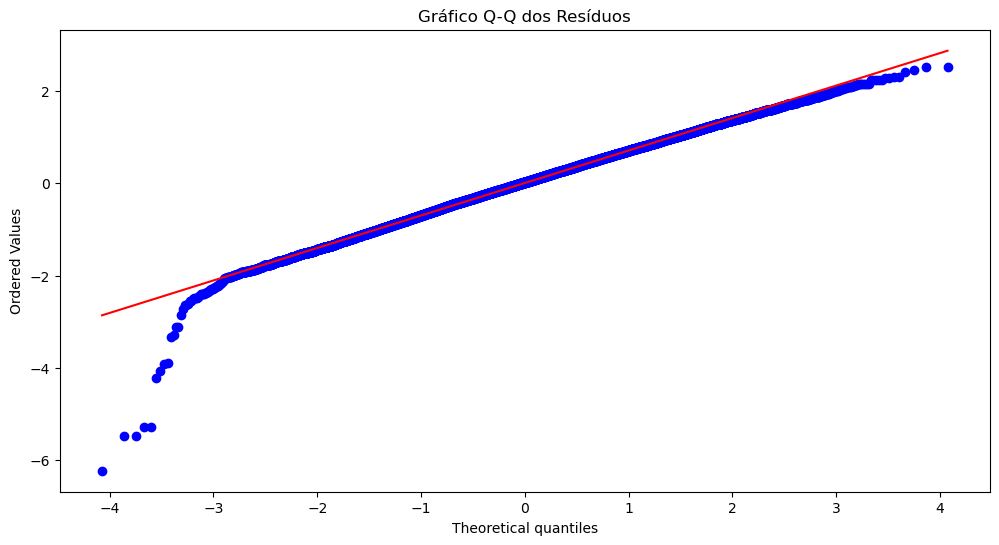

In [122]:
# Gráfico Q-Q
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Gráfico Q-Q dos Resíduos')
plt.show()

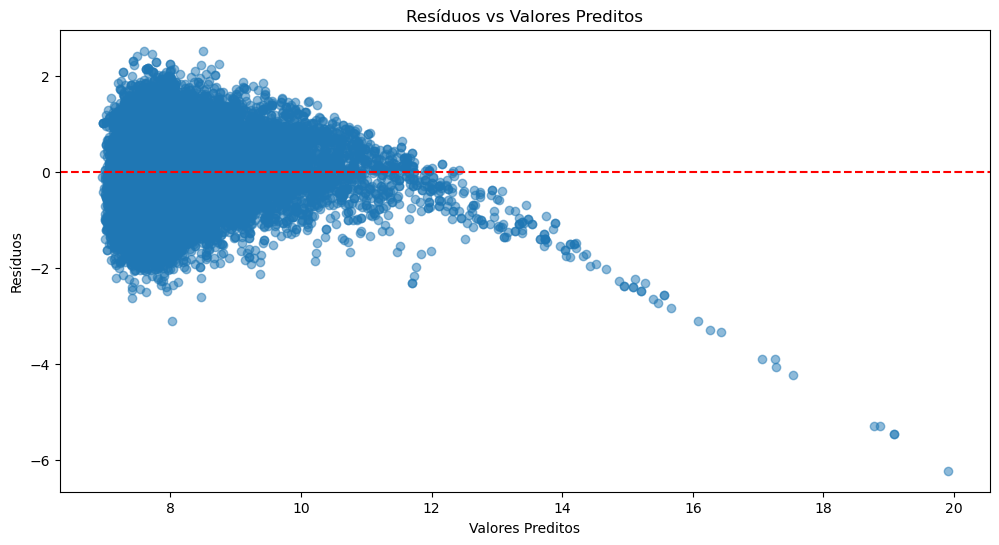

In [123]:
# Resíduos vs Valores Preditos
plt.figure(figsize=(12, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Preditos')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


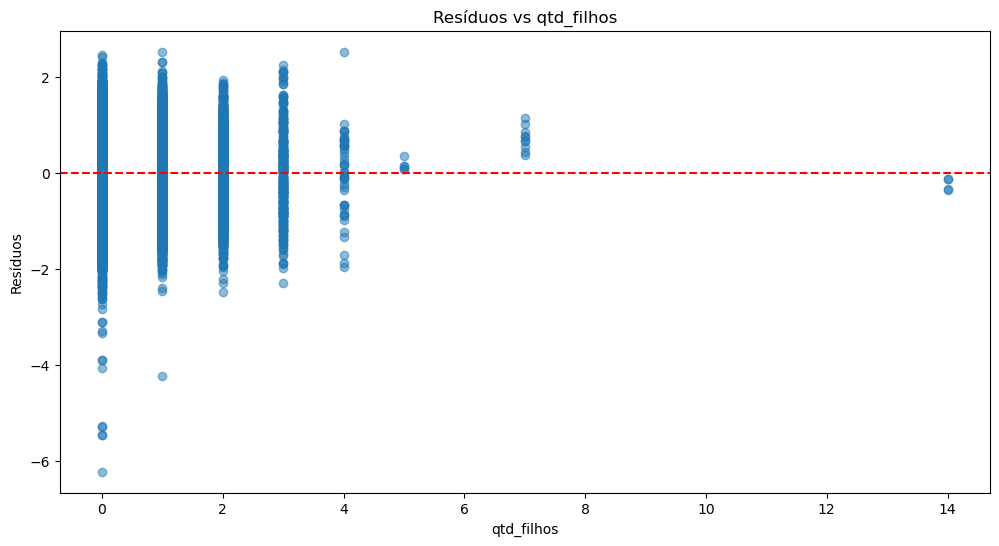

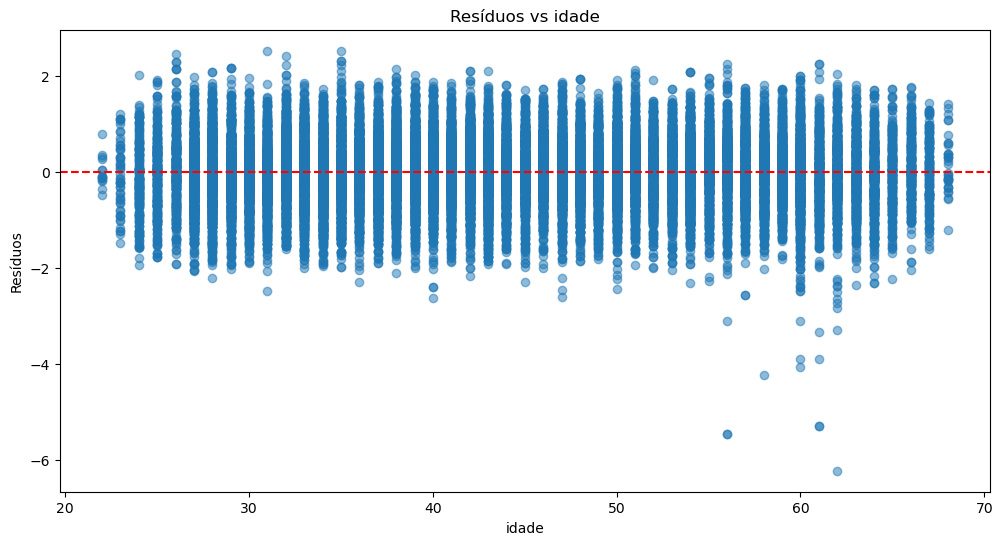

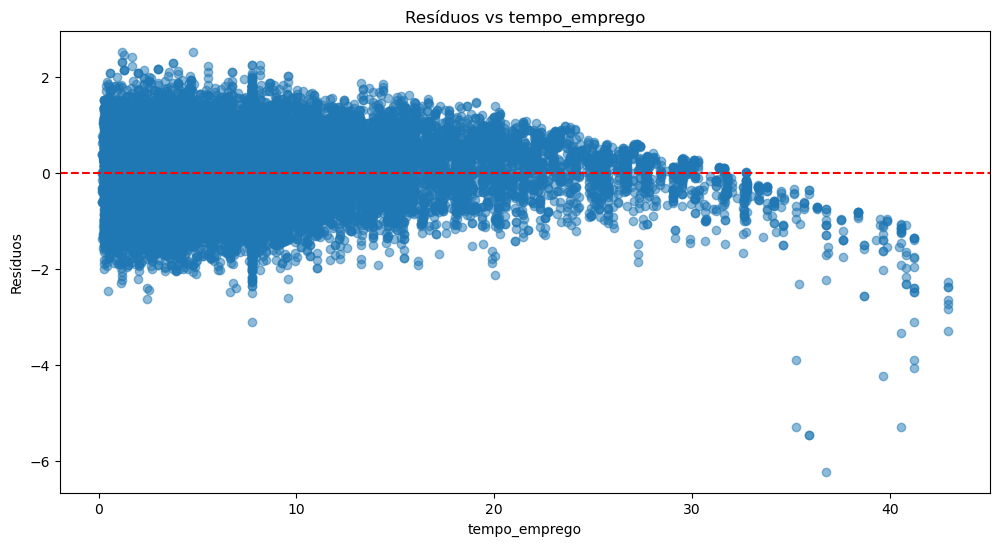

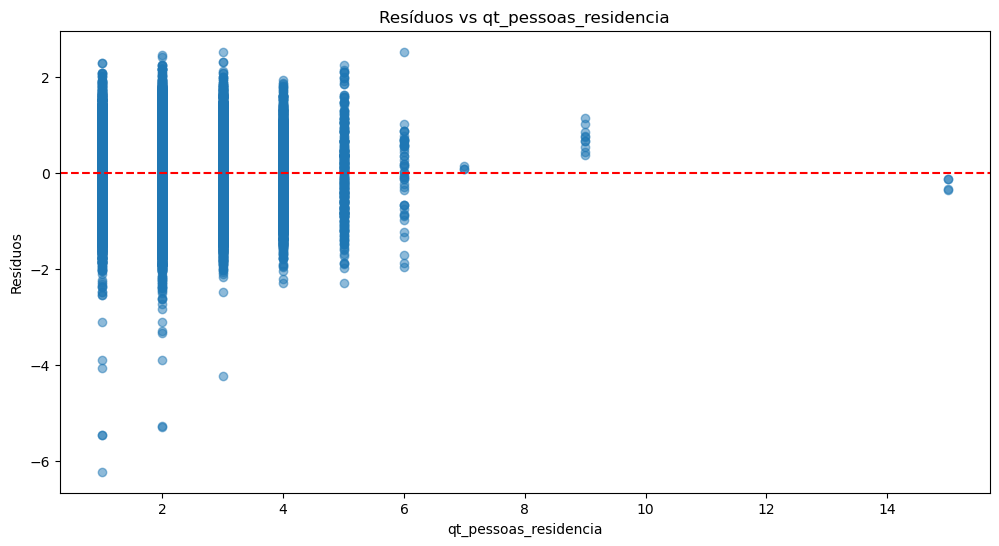

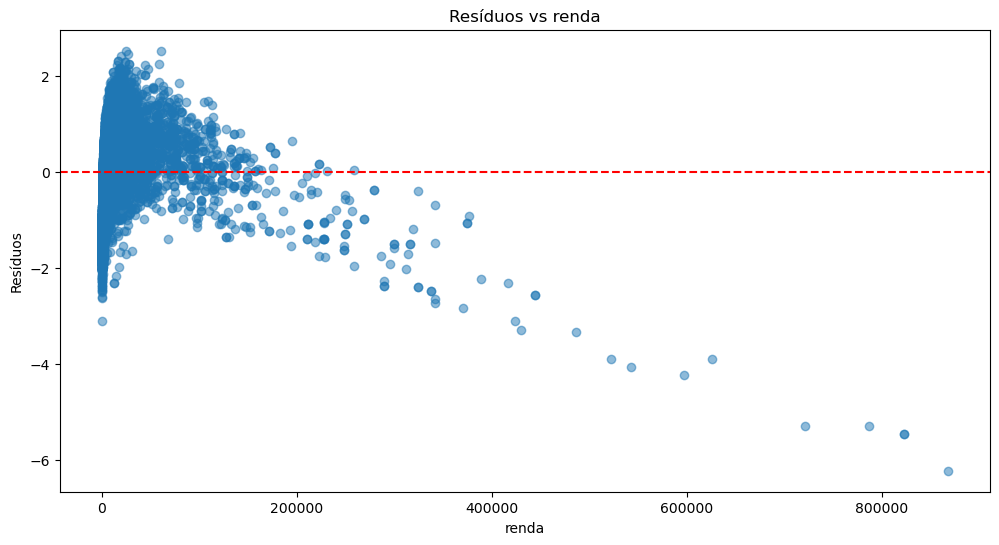

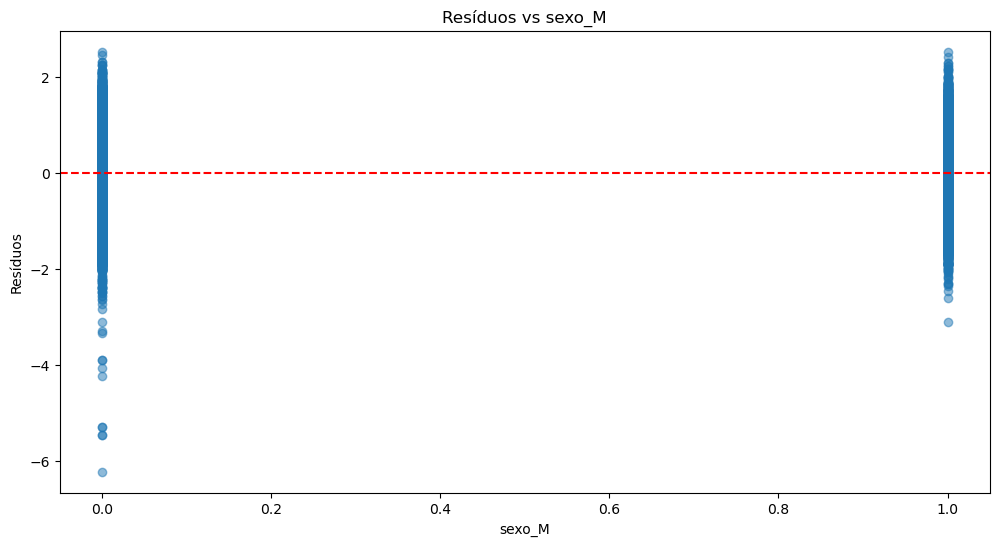

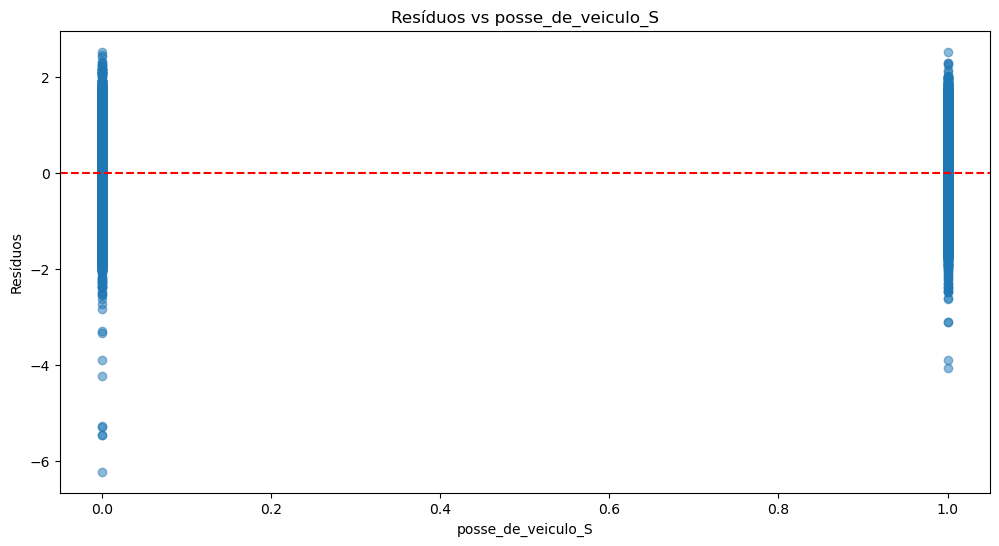

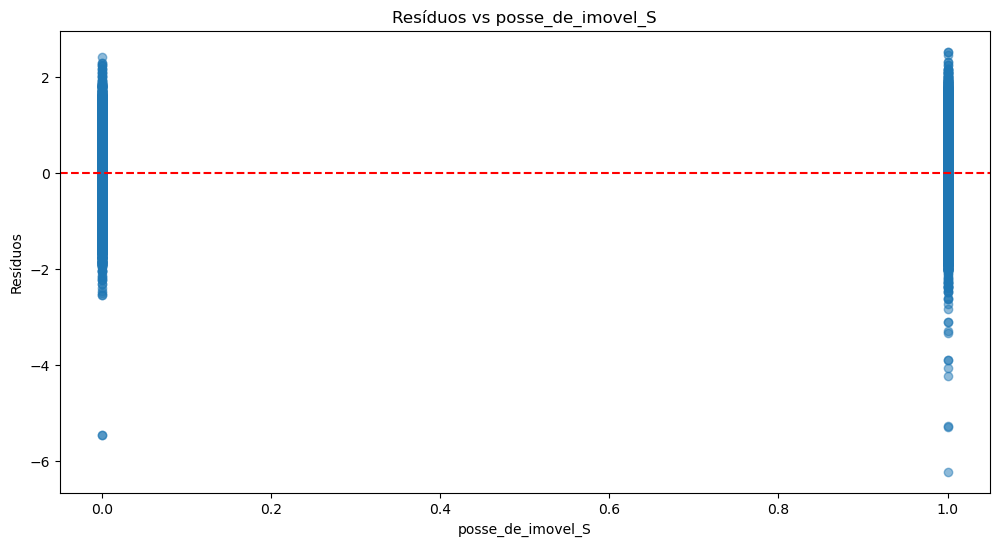

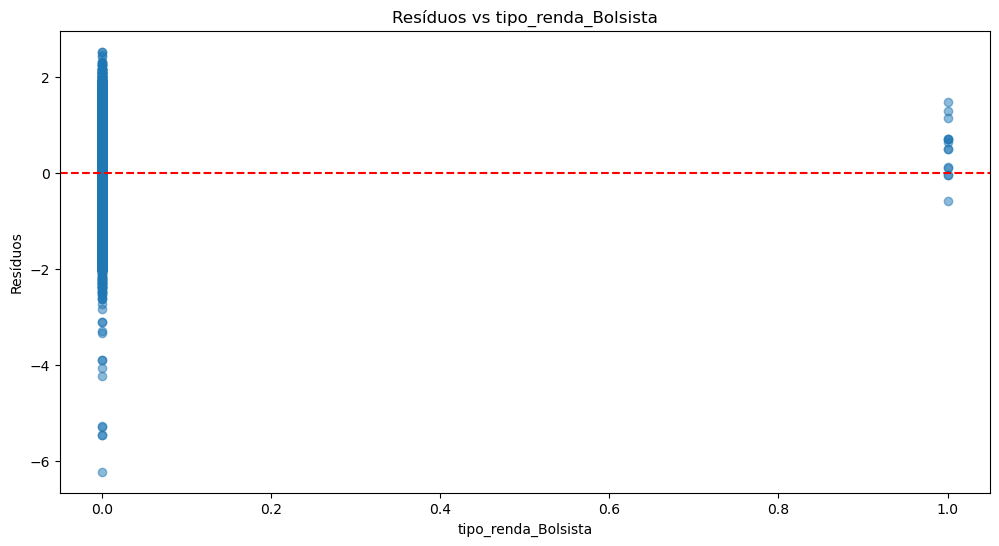

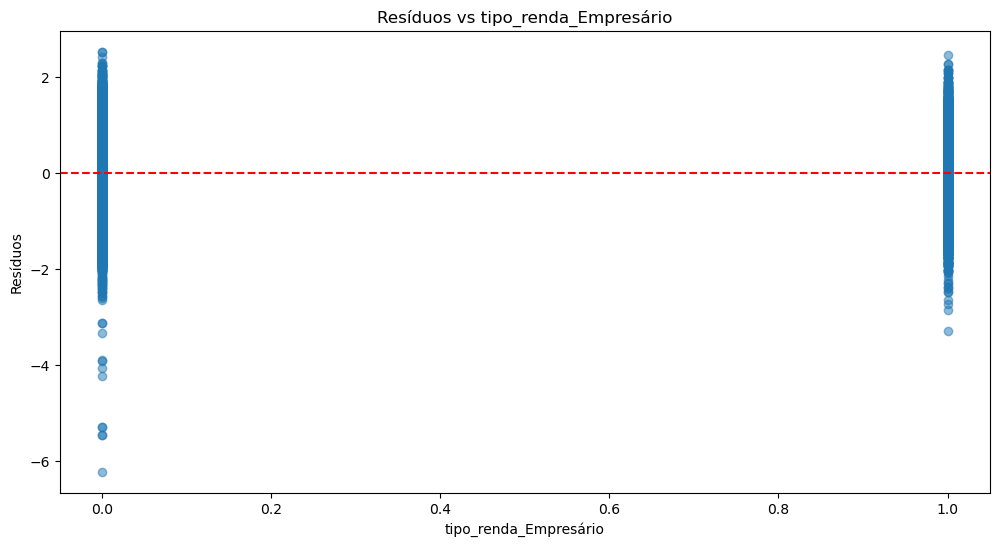

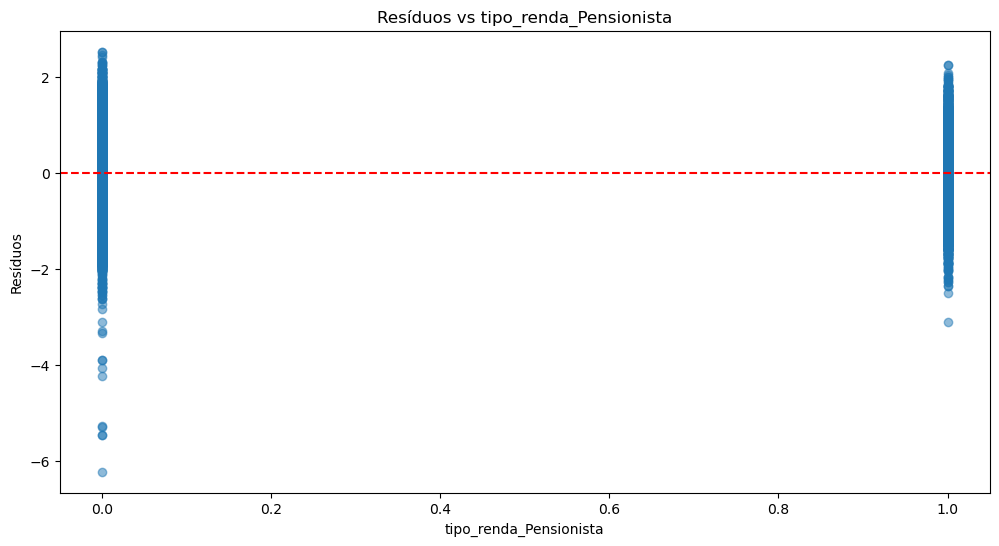

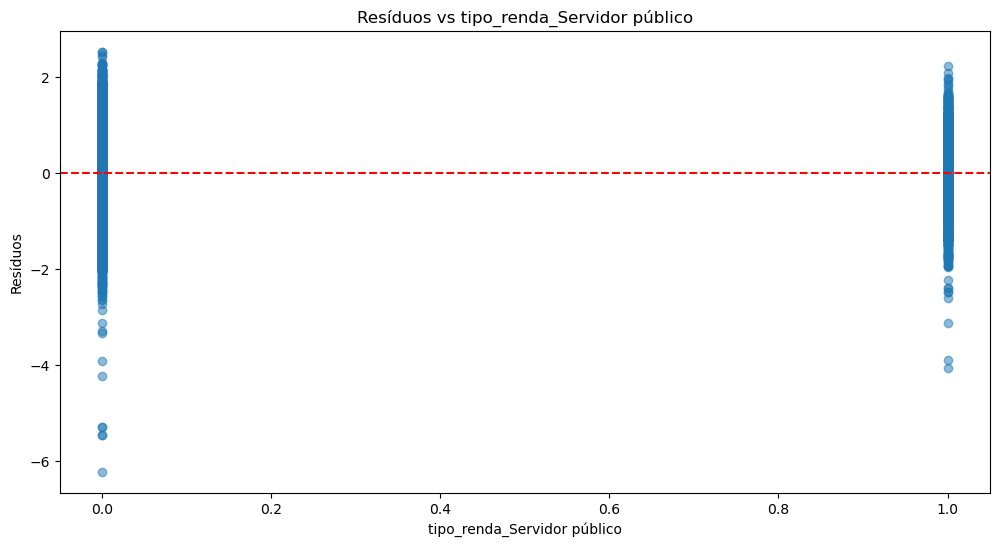

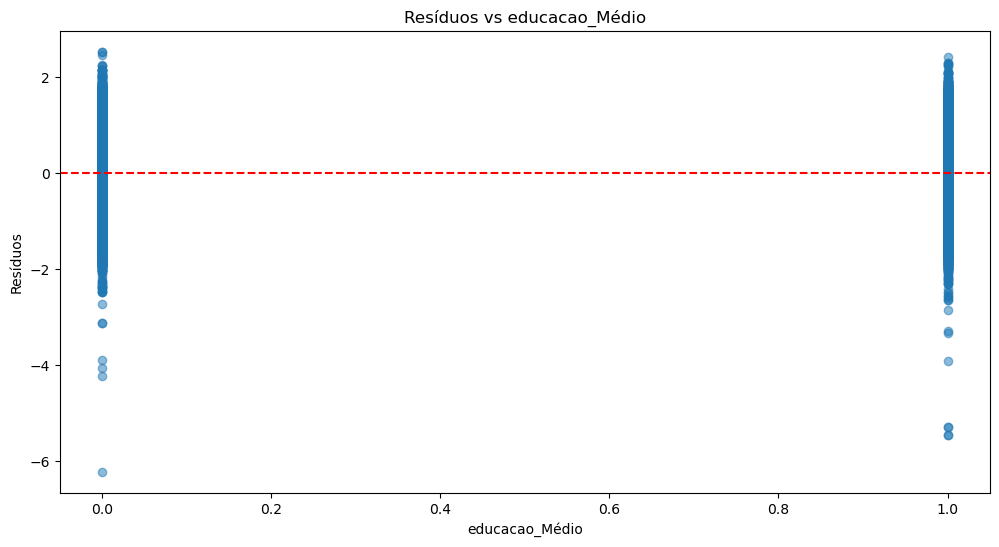

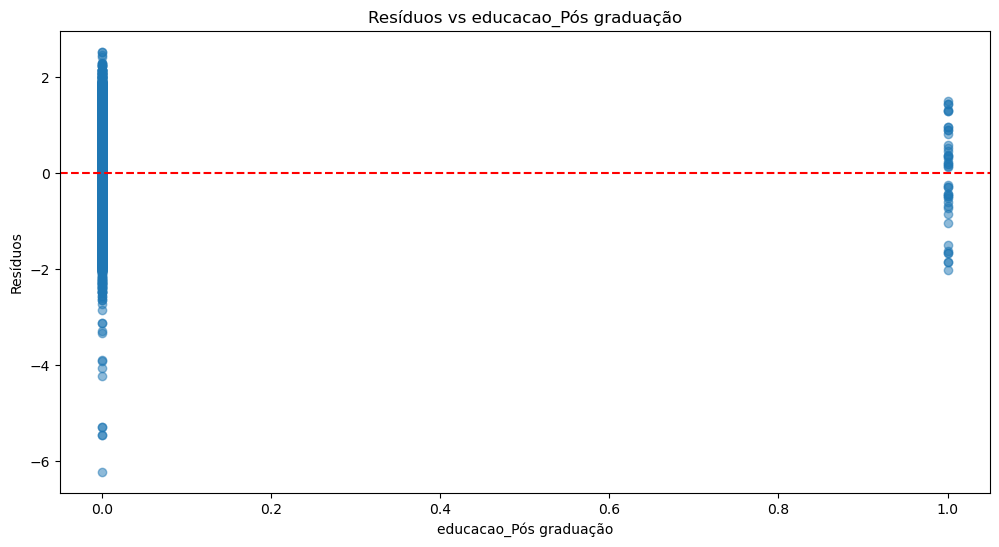

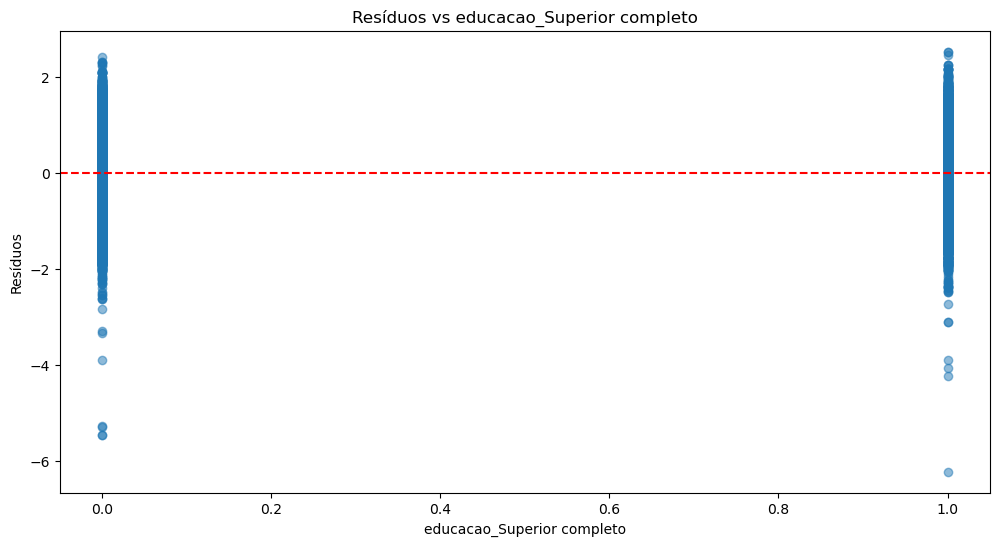

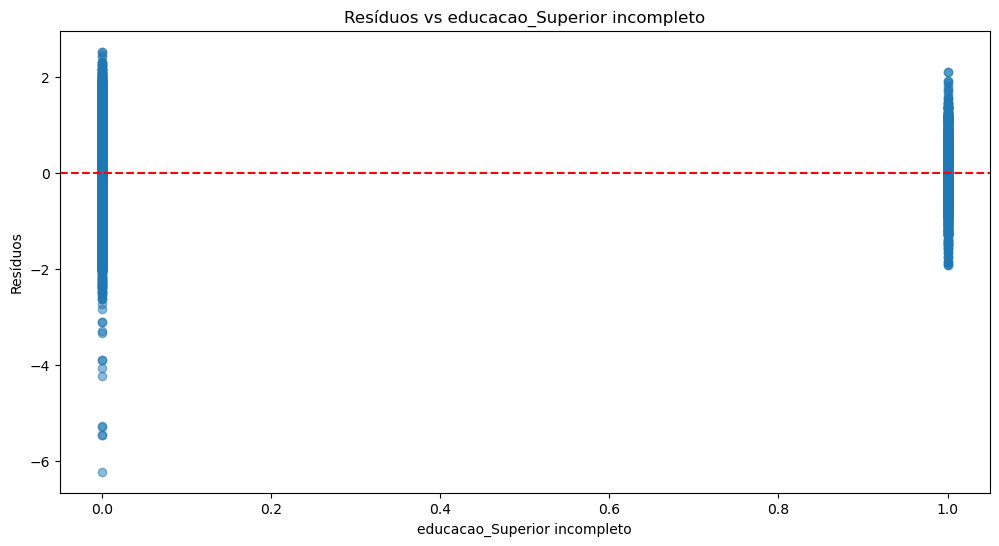

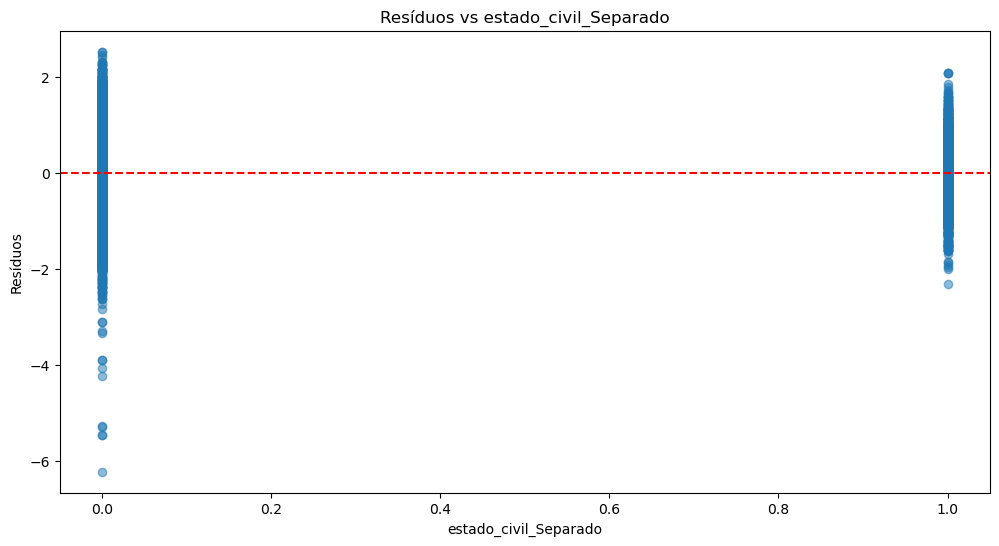

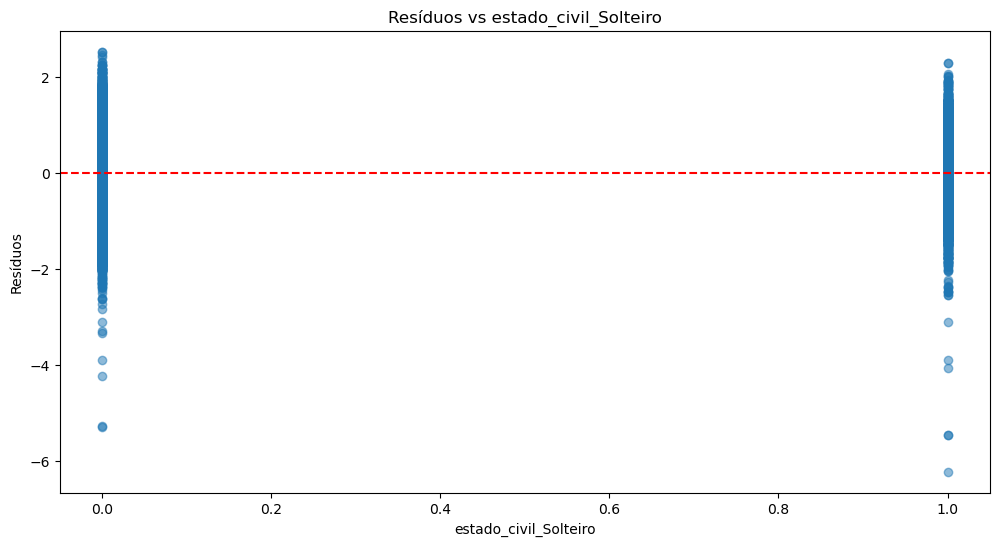

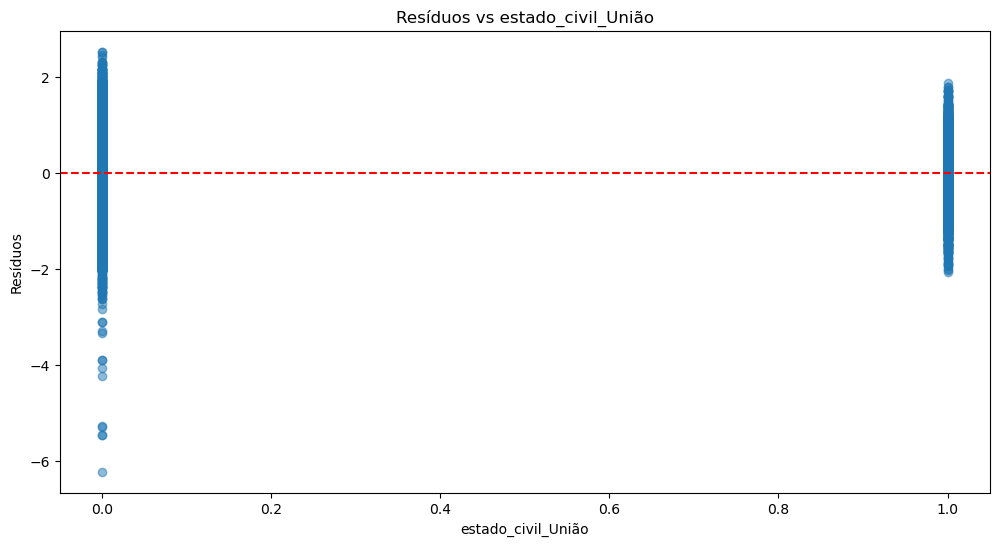

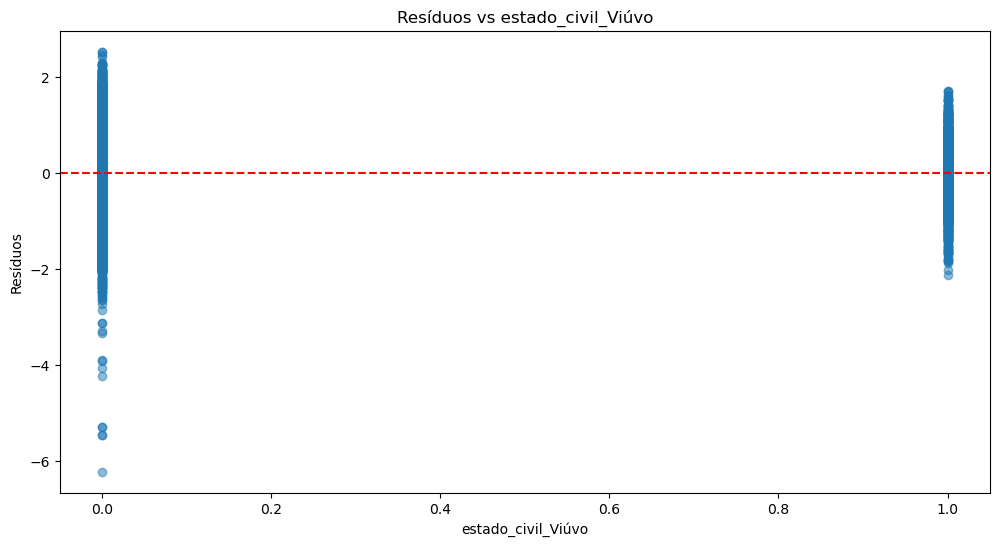

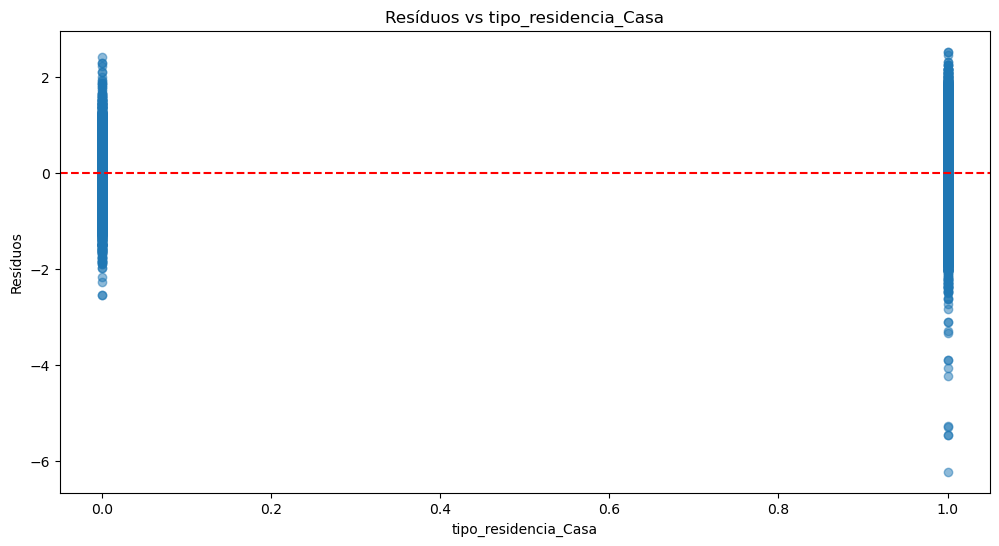

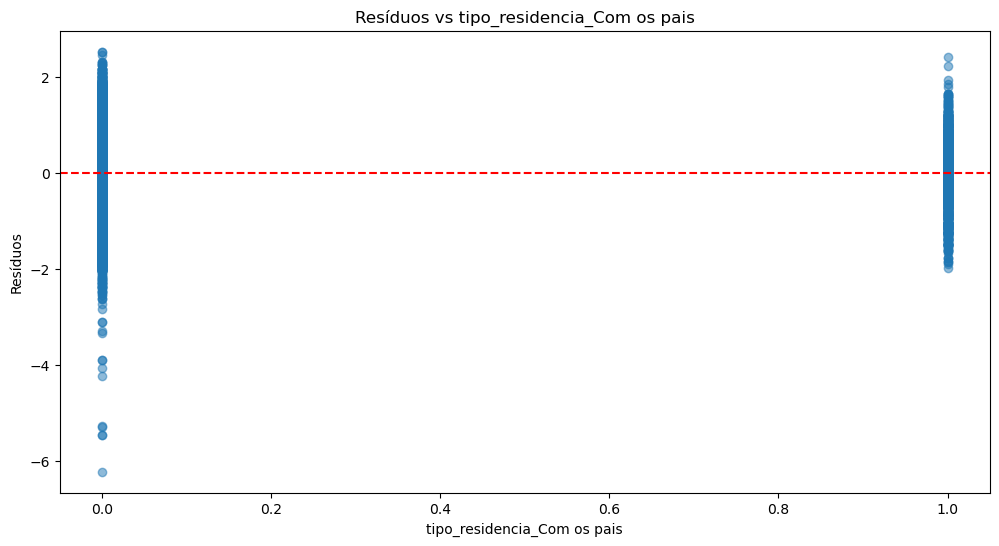

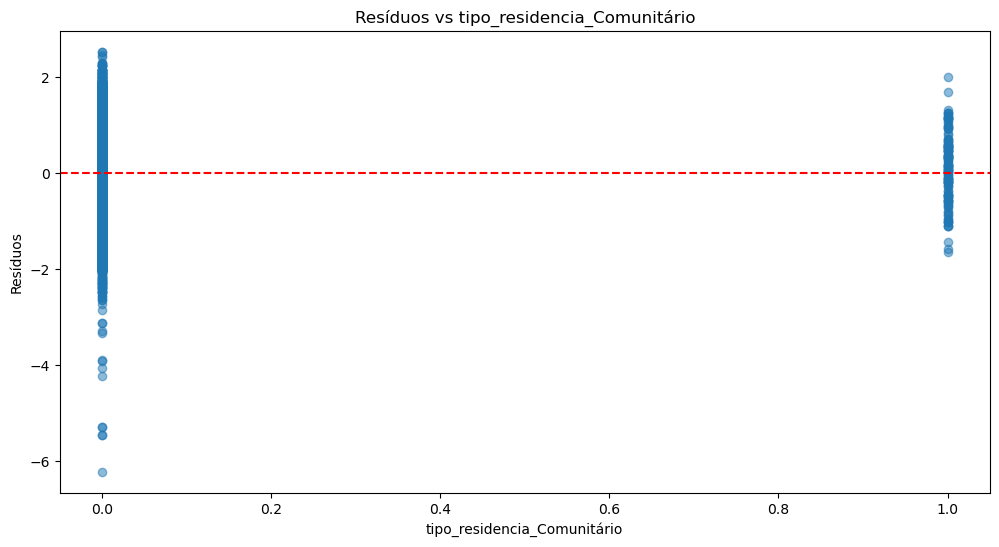

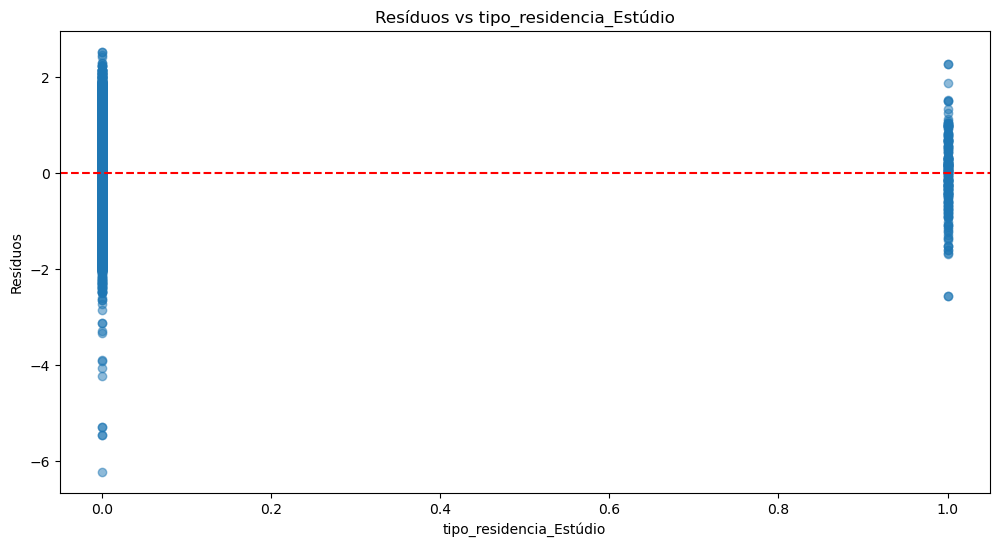

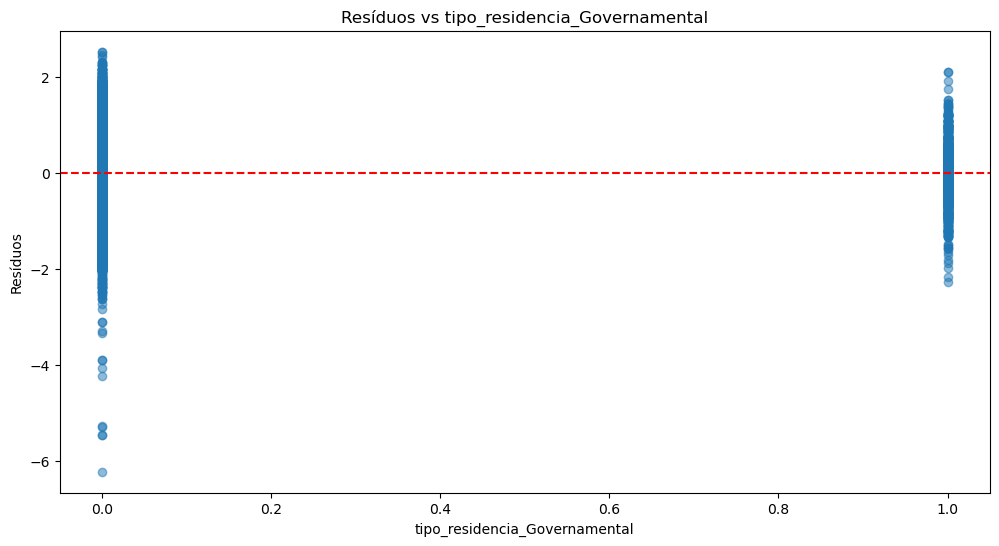

In [124]:
# Calcule os resíduos no conjunto de teste
residuals = y_test - y_pred

# Adicione os resíduos ao DataFrame de teste para garantir o alinhamento
test_data = X_test.copy()
test_data['residuals'] = residuals

# Plotar resíduos vs cada variável independente
for col in X_test.columns:
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data[col], test_data['residuals'], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('Resíduos')
    plt.title(f'Resíduos vs {col}')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

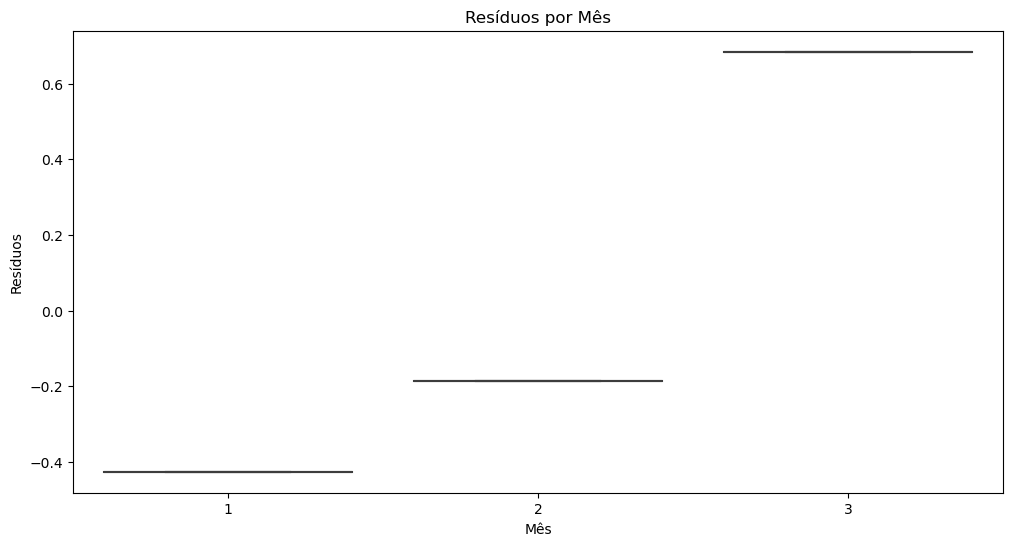

In [125]:
df = df[~df.index.duplicated(keep='first')]
residuals = residuals[~residuals.index.duplicated(keep='first')]

# Se o índice temporal está no DataFrame original, extraia o mês para o conjunto de teste
df_test = df.loc[X_test.index]
df_test['residuals'] = residuals

# Plotar resíduos por mês
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_test.index.month, y='residuals', data=df_test)
plt.xlabel('Mês')
plt.ylabel('Resíduos')
plt.title('Resíduos por Mês')
plt.show()

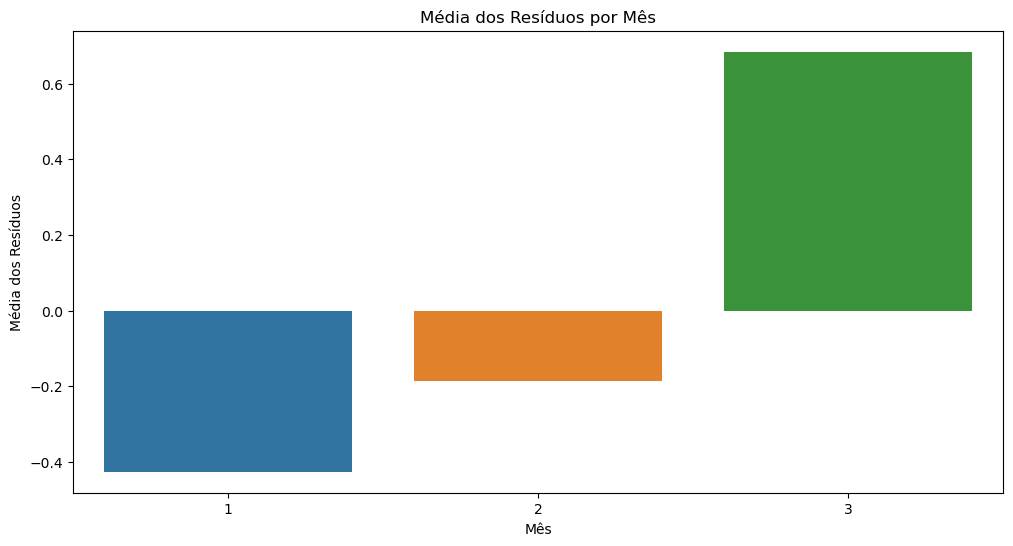

In [126]:
# Se o índice temporal está no DataFrame original, extraia o mês para o conjunto de teste
df_test = df.loc[X_test.index]
df_test['residuals'] = residuals

df_sample = df.sample(frac=1, random_state=42)

# Garantir que X_test também está amostrado da mesma forma
X_test_sample = X_test.loc[df_sample.index.intersection(X_test.index)]
residuals_sample = residuals.loc[df_sample.index.intersection(residuals.index)]

# Adicionar resíduos à amostra do conjunto de teste
df_test_sample = df.loc[X_test_sample.index]
df_test_sample['residuals'] = residuals_sample

# Filtrar dados para um período específico, se aplicável
# df_filtered = df[df['data_column'] < some_threshold]

# Calcular média e variância dos resíduos por mês
monthly_stats = df_test_sample.groupby(df_test_sample.index.month)['residuals'].agg(['mean', 'var']).reset_index()
monthly_stats.columns = ['Month', 'Mean Residuals', 'Variance Residuals']

# Plotar média dos resíduos por mês
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Mean Residuals', data=monthly_stats)
plt.xlabel('Mês')
plt.ylabel('Média dos Resíduos')
plt.title('Média dos Resíduos por Mês')
plt.show()

In [127]:
print("Tamanho dos resíduos:", len(residuals))
print("Tamanho de X_test:", len(X_test))
print("Tamanho de X_test[col]:", len(X_test[col]))

print(X_test.head())
residuals.head()


Tamanho dos resíduos: 3
Tamanho de X_test: 30000
Tamanho de X_test[col]: 30000
            qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia     renda  \
data_ref                                                                        
2016-02-01           1     34      14.619178                    2.0   4349.39   
2016-01-01           0     58       7.746165                    2.0   1750.54   
2016-03-01           0     40       5.717808                    2.0   4682.43   
2016-03-01           0     24       1.641096                    1.0    683.34   
2016-03-01           0     46      20.117808                    2.0  30744.47   

            sexo_M  posse_de_veiculo_S  posse_de_imovel_S  \
data_ref                                                    
2016-02-01   False               False              False   
2016-01-01   False               False               True   
2016-03-01    True               False              False   
2016-03-01    True               False          

data_ref
2016-02-01   -0.187516
2016-01-01   -0.426019
2016-03-01    0.684184
Name: renda_log, dtype: float64

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

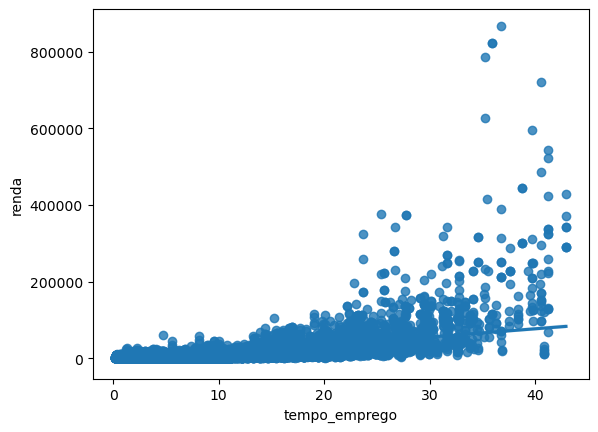

In [128]:
fig, ax = plt.subplots()

sns.regplot(x = 'tempo_emprego', y = 'renda', data=test_data, ax=ax);

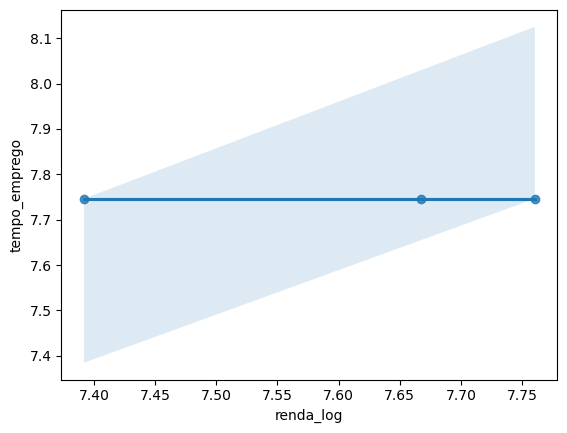

In [129]:
fig, ax = plt.subplots()

sns.regplot(x = 'renda_log', y = 'tempo_emprego', data=df, ax=ax);

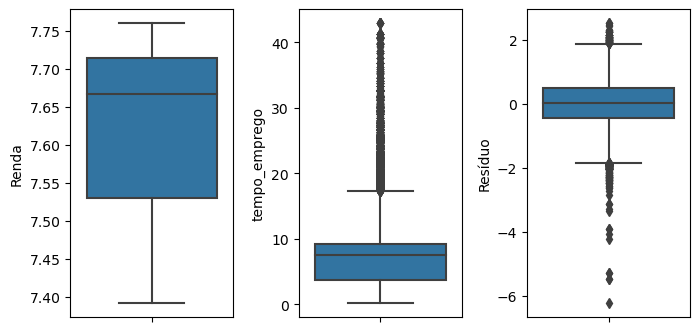

In [130]:
fix, ax = plt.subplots(1, 3, figsize=(8,4))
plt.subplots_adjust(wspace=.4, hspace=0)

sns.boxplot(y = 'renda_log',data=df, ax=ax[0])
sns.boxplot(y = 'tempo_emprego',data=test_data, ax=ax[1])
sns.boxplot(y = 'residuals' ,data=test_data, ax=ax[2]);

ax[0].set_ylabel('Renda')
ax[2].set_ylabel('Tempo de emprego')
ax[2].set_ylabel('Resíduo');

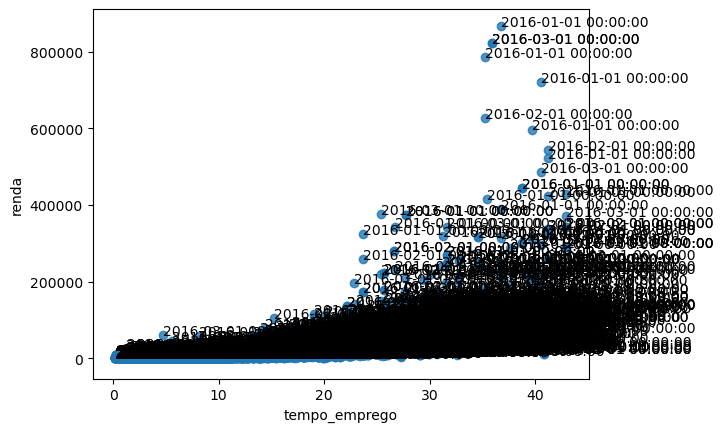

In [131]:
fig, ax = plt.subplots()

# Gráfico de dispersão com linha de regressão
sns.regplot(x='tempo_emprego', y='renda', data=test_data, ax=ax)

# Anotações aos pontos
for i in range(len(test_data)):
    txt = test_data.index[i]
    ax.annotate(str(txt), 
                (test_data.iloc[i]['tempo_emprego'], test_data.iloc[i]['renda']))
plt.show()

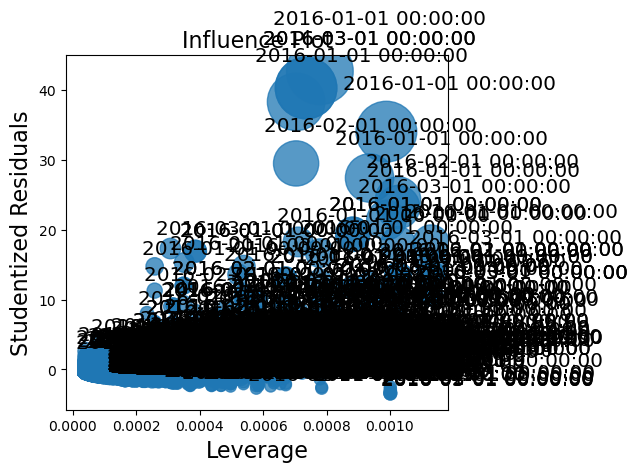

In [132]:
# Avaliando os *studentized residuals* e Leverage
reg = smf.ols('renda ~ tempo_emprego', data=test_data).fit()

fig = sm.graphics.influence_plot(reg, criterion="cooks")
fig.tight_layout(pad=1.0)

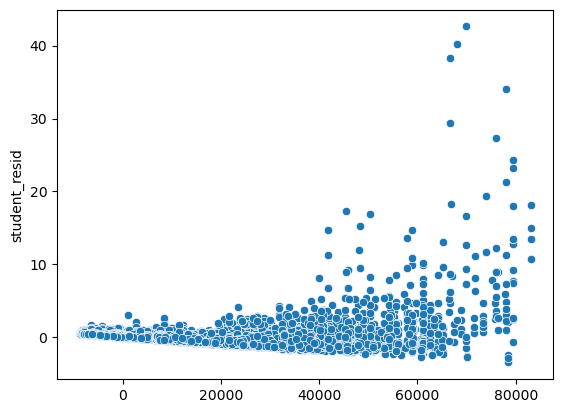

In [133]:
# Testando se há pontos que parecem ser discrepantes
st_res = reg.outlier_test()
sns.scatterplot(x = reg.predict(), y = st_res.student_resid);

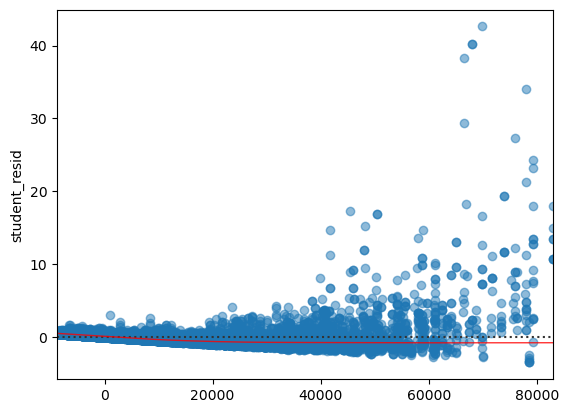

In [134]:
sns.residplot(x=reg.predict(), y=st_res.student_resid, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

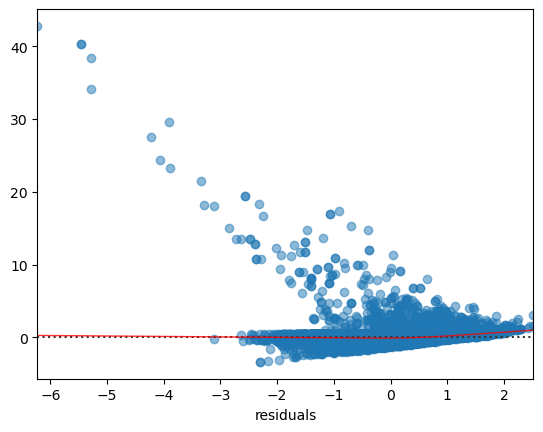

In [135]:
sns.residplot(x=test_data['residuals'], y=st_res.student_resid.values, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

c:\Users\Xam_j\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


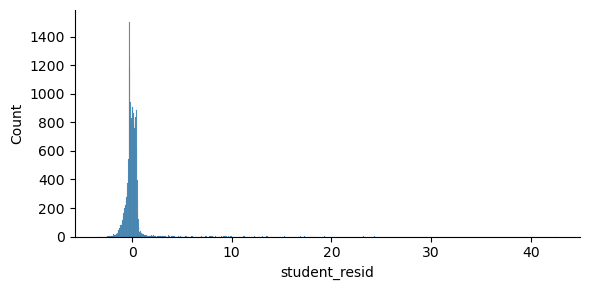

In [136]:
sns.displot(st_res.student_resid, height=3, aspect=2);

In [137]:
resumo = reg.summary()
resumo.tables[2]

Omnibus:,60940.263,Durbin-Watson:,1.942
Prob(Omnibus):,0.000,Jarque-Bera (JB):,302293443.843
Skew:,16.777,Prob(JB):,0.00
Kurtosis:,493.621,Cond. No.,16.1


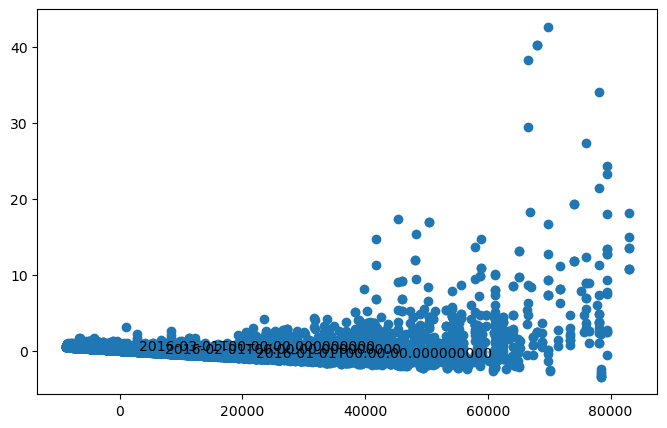

In [138]:
fig, ax = plt.subplots(figsize=(8,5))

st_res = reg.outlier_test()
ax.scatter(x = reg.predict(), y = st_res.student_resid)

for i, txt in enumerate(df.index.values):
    ax.annotate(str(txt), (reg.predict()[i], st_res.student_resid[i]))

plt.show()

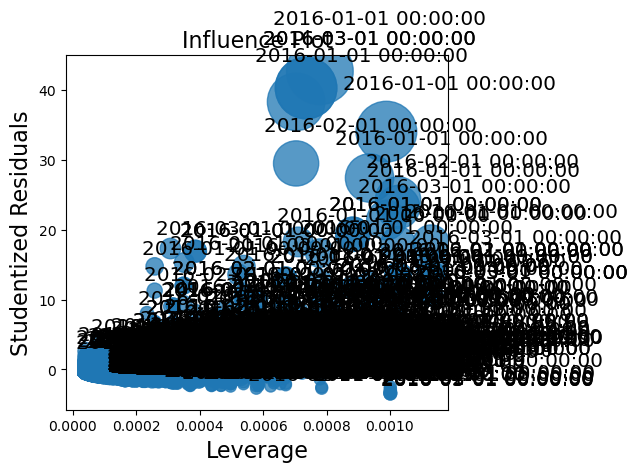

In [139]:
# Pontos influêntes 

fig = sm.graphics.influence_plot(reg, criterion="cooks")
fig.tight_layout(pad=1.0)

In [140]:
df.sort_values(by='tempo_emprego').head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
data_ref,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0,61,7.746165,2.0,2137.61,7.667444,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
2016-02-01,0,57,7.746165,1.0,1622.72,7.391859,False,False,True,False,...,False,False,False,False,True,True,False,False,False,False
2016-03-01,0,64,7.746165,2.0,2345.74,7.760356,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False


In [141]:
df.sort_values(by='renda_log', ascending=False).head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
data_ref,,,,,,,,,,,,,,,,,,,,,
2016-03-01,0,64,7.746165,2.0,2345.74,7.760356,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
2016-01-01,0,61,7.746165,2.0,2137.61,7.667444,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
2016-02-01,0,57,7.746165,1.0,1622.72,7.391859,False,False,True,False,...,False,False,False,False,True,True,False,False,False,False


In [142]:
df.sort_values(by='renda_log', ascending=True).head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
data_ref,,,,,,,,,,,,,,,,,,,,,
2016-02-01,0,57,7.746165,1.0,1622.72,7.391859,False,False,True,False,...,False,False,False,False,True,True,False,False,False,False
2016-01-01,0,61,7.746165,2.0,2137.61,7.667444,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
2016-03-01,0,64,7.746165,2.0,2345.74,7.760356,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False


In [143]:
df2 = df[  (df['renda_log']<13.7) & (df['renda_log']>4.6)].dropna()
reg = smf.ols('renda_log ~ tempo_emprego', 
              data=df2).fit()


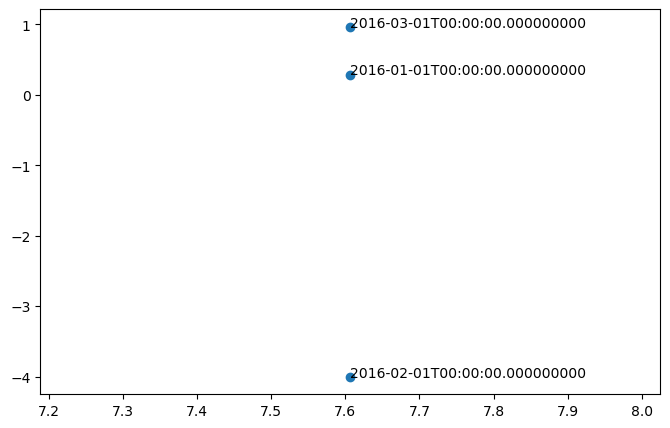

In [144]:
fig, ax = plt.subplots(figsize=(8,5))

st_res = reg.outlier_test()
ax.scatter(x = reg.predict(), y = st_res.student_resid)

for i, txt in enumerate(df2.index.values):
    ax.annotate(str(txt), (reg.predict()[i], st_res.student_resid.values[i]))

plt.show()

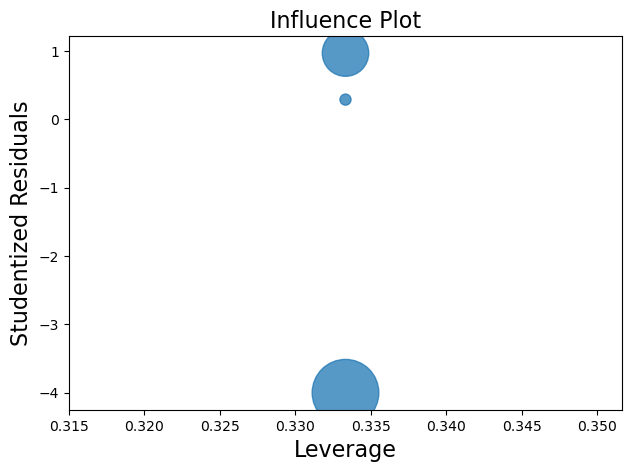

In [145]:
fig = sm.graphics.influence_plot(reg, criterion="cooks")
fig.tight_layout(pad=1.0)

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [88]:
import scipy.stats as ss 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [146]:
# Verificar a correlação de Spearman entre as variaveis
correlation_matrix_ = df_.corr(method='spearman')
correlation_matrix_

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,renda_log,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
qtd_filhos,1.000000,-0.414219,-0.083973,0.828717,-0.017183,-0.017183,0.114595,0.118843,-0.017247,-0.014484,...,0.033791,-0.013663,-0.131127,0.013679,-0.109825,-0.044468,0.044431,-0.008891,0.036189,0.004310
idade,-0.414219,1.000000,0.297054,-0.349713,0.123072,0.123072,-0.212807,-0.163784,0.131603,0.015727,...,-0.152973,0.058062,-0.069020,-0.059379,0.217275,0.156398,-0.190220,-0.017660,-0.005933,0.009612
tempo_emprego,-0.083973,0.297054,1.000000,-0.055938,0.600791,0.600791,-0.129630,-0.066763,0.018116,0.023415,...,-0.057479,0.000590,-0.042352,-0.020712,0.051804,0.067399,-0.088281,-0.037716,0.027826,0.009497
qt_pessoas_residencia,0.828717,-0.349713,-0.055938,1.000000,-0.003239,-0.003239,0.153924,0.170673,-0.018991,-0.003933,...,0.018653,-0.264520,-0.489036,0.096119,-0.303638,-0.023018,0.028637,-0.004463,0.029313,-0.000342
renda,-0.017183,0.123072,0.600791,-0.003239,1.000000,1.000000,0.004393,0.002884,0.080226,0.005375,...,-0.032969,0.010371,-0.022533,-0.014698,-0.006096,0.038186,-0.046270,-0.022150,0.014872,-0.001923
renda_log,-0.017183,0.123072,0.600791,-0.003239,1.000000,1.000000,0.004393,0.002884,0.080226,0.005375,...,-0.032969,0.010371,-0.022533,-0.014698,-0.006096,0.038186,-0.046270,-0.022150,0.014872,-0.001923
sexo_M,0.114595,-0.212807,-0.129630,0.153924,0.004393,0.004393,1.000000,0.367579,-0.055747,-0.015347,...,0.022930,-0.059065,-0.033838,-0.027072,-0.138566,-0.063991,0.053764,0.020370,0.055382,-0.020429
posse_de_veiculo_S,0.118843,-0.163784,-0.066763,0.170673,0.002884,0.002884,0.367579,1.000000,-0.028143,-0.017532,...,0.021351,-0.075046,-0.081717,-0.037343,-0.090033,-0.023539,0.021904,0.031580,0.030696,-0.017795
posse_de_imovel_S,-0.017247,0.131603,0.018116,-0.018991,0.080226,0.080226,-0.055747,-0.028143,1.000000,0.015365,...,-0.045247,-0.020400,0.004712,-0.032112,0.040470,0.203133,-0.156978,-0.022864,-0.039796,-0.120090
tipo_renda_Bolsista,-0.014484,0.015727,0.023415,-0.003933,0.005375,0.005375,-0.015347,-0.017532,0.015365,1.000000,...,-0.004417,-0.005355,-0.008224,-0.006374,-0.004567,0.007358,-0.004721,-0.001454,-0.001862,-0.003923


In [158]:
# Tornando os dados em formato float
df_values = np.array(df_.values, dtype=float)

# Calculando o VIF
def calculate_vif(df_values):
    vif_data = pd.DataFrame()
    vif_data["VIF Factor"] = [vif(df_values, i) for i in range(df_values.shape[1])]
    vif_data["Variavel"] = df_.columns
    return vif_data

vif_result = calculate_vif(df_values)
vif_result.round(2)


,VIF Factor,Variavel
0,47.26,qtd_filhos
1,34.64,idade
2,6.29,tempo_emprego
3,341.09,qt_pessoas_residencia
4,1.73,renda
5,127.23,renda_log
6,1.84,sexo_M
7,1.96,posse_de_veiculo_S
8,3.28,posse_de_imovel_S
9,1.00,tipo_renda_Bolsista


In [163]:
r1 = smf.ols('''
    renda_log ~ qtd_filhos + idade + tempo_emprego + qt_pessoas_residencia + renda + sexo_M + posse_de_veiculo_S
              + posse_de_imovel_S + tipo_renda_Bolsista + tipo_renda_Empresário + tipo_renda_Pensionista
              + estado_civil_Separado + estado_civil_Solteiro + estado_civil_União
              + estado_civil_Viúvo + tipo_residencia_Casa + tipo_residencia_Comunitário 
              + tipo_residencia_Estúdio + tipo_residencia_Governamental
    ''', data=df_dum.dropna()).fit()
r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                 1.086e+04
Date:                Sat, 10 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:09:30   Log-Likelihood:            -1.6105e+05
No. Observations:              150000   AIC:                         3.221e+05
Df Residuals:                  149980   BIC:                         3.223e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 6.5732      0.069     95.072      0.000       6.438       6.709
sexo_M[T.True]                            0.1289      0.004     29.985      0.000       0.120       0.137
posse_de_veiculo_S[T.True]                0.0186      0.004      4.550      0.000       0.011       0.027
posse_de_imovel_S[T.True]                 0.1706      0.004     42.561      0.000       0.163       0.178
tipo_renda_Bolsista[T.True]              -0.1878      0.084     -2.247      0.025      -0.352      -0.024
tipo_renda_Empresário[T.True]             0.1279      0.005     28.321      0.000       0.119       0.137
tipo_renda_Pensionista[T.True]           -0.2563      0.007    -38.957      0.000      -0.269      -0.243
estado_civil_Separado[T.True]             0.2044      0.035      5.839      0.000       0.136       0.273
estado_civil_Solteiro[T.True]             0.1544      0.034      4.500      0.000       0.087       0.222
estado_civil_União[T.True]                0.0036      0.007      0.525      0.600      -0.010       0.017
estado_civil_Viúvo[T.True]                0.1918      0.035      5.418      0.000       0.122       0.261
tipo_residencia_Casa[T.True]             -0.0269      0.008     -3.340      0.001      -0.043      -0.011
tipo_residencia_Comunitário[T.True]      -0.0966      0.029     -3.366      0.001      -0.153      -0.040
tipo_residencia_Estúdio[T.True]          -0.0396      0.023     -1.725      0.085      -0.085       0.005
tipo_residencia_Governamental[T.True]    -0.0211      0.013     -1.632      0.103      -0.047       0.004
qtd_filhos                               -0.1666      0.034     -4.878      0.000      -0.234      -0.100
idade                                     0.0029      0.000     12.415      0.000       0.002       0.003
tempo_emprego                             0.1080      0.000    287.551      0.000       0.107       0.109
qt_pessoas_residencia                     0.1776      0.034      5.213      0.000       0.111       0.244
renda                                  1.019e-05   9.21e-08    110.626      0.000       1e-05    1.04e-05
==============================================================================
Omnibus:                     4968.811   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8880.851
Skew:                          -0.277   Prob(JB):                         0.00
Kurtosis:                       4.056   Cond. No.                     1.41e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+06. This might indicate that t

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [165]:
variaveis = ['qtd_filhos', 'idade', 'tempo_emprego', 'renda', 'sexo_M', 
             'posse_de_veiculo_S', 'posse_de_imovel_S', 'tipo_renda_Bolsista', 'tipo_renda_Empresário', 
             'tipo_renda_Pensionista', 'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União', 
             'estado_civil_Viúvo', 'tipo_residencia_Comunitário', 
             'tipo_residencia_Estúdio', 'tipo_residencia_Governamental']

df_dum = pd.get_dummies(df_[variaveis], drop_first=True)
df_dum.head()

,qtd_filhos,idade,tempo_emprego,renda,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
data_ref,,,,,,,,,,,,,,,,,
2016-01-01,0,61,7.746165,2137.61,False,False,True,False,False,True,False,False,False,False,False,False,False
2016-01-01,2,27,9.301370,13884.35,False,False,True,False,False,False,False,False,False,False,False,False,False
2016-01-01,3,38,10.967123,11042.47,False,True,True,False,False,False,False,False,False,False,False,False,False
2016-01-01,3,35,5.553425,1333.82,True,True,True,False,False,False,False,False,False,False,False,False,False
2016-01-01,0,63,9.265753,17633.03,False,True,False,False,False,False,False,False,False,True,False,False,False


In [167]:
# Tornando os dados em formato float
df_values = np.array(df_dum.values, dtype=float)

# Calculando o VIF
def calculate_vif(df_values):
    vif_data = pd.DataFrame()
    vif_data["VIF Factor"] = [vif(df_values, i) for i in range(df_values.shape[1])]
    vif_data["Variavel"] = df_dum.columns
    return vif_data

vif_result = calculate_vif(df_values)
vif_result.round(2)

,VIF Factor,Variavel
0,1.38,qtd_filhos
1,8.57,idade
2,4.09,tempo_emprego
3,1.59,renda
4,1.75,sexo_M
5,1.90,posse_de_veiculo_S
6,3.08,posse_de_imovel_S
7,1.00,tipo_renda_Bolsista
8,1.37,tipo_renda_Empresário
9,1.87,tipo_renda_Pensionista


In [169]:
r1 = smf.ols('''
    renda ~ qtd_filhos + idade + tempo_emprego + sexo_M + posse_de_veiculo_S
              + posse_de_imovel_S + tipo_renda_Bolsista + tipo_renda_Empresário + tipo_renda_Pensionista
              + estado_civil_Separado + estado_civil_Solteiro + estado_civil_União
              + estado_civil_Viúvo + tipo_residencia_Comunitário 
              + tipo_residencia_Estúdio + tipo_residencia_Governamental
    ''', data=df_dum.dropna()).fit()
r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     4354.
Date:                Sat, 10 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:25:19   Log-Likelihood:            -1.6973e+06
No. Observations:              150000   AIC:                         3.395e+06
Df Residuals:                  149983   BIC:                         3.395e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                             -1.273e+04    297.814    -42.732      0.000   -1.33e+04   -1.21e+04
sexo_M[T.True]                         -905.8259    120.437     -7.521      0.000   -1141.880    -669.772
posse_de_veiculo_S[T.True]             -152.5768    114.633     -1.331      0.183    -377.254      72.101
posse_de_imovel_S[T.True]              1633.2641    111.310     14.673      0.000    1415.098    1851.430
tipo_renda_Bolsista[T.True]           -1.101e+04   2343.044     -4.700      0.000   -1.56e+04   -6419.894
tipo_renda_Empresário[T.True]           909.7238    126.611      7.185      0.000     661.568    1157.879
tipo_renda_Pensionista[T.True]        -6867.6575    183.615    -37.402      0.000   -7227.540   -6507.775
estado_civil_Separado[T.True]           497.6186    226.470      2.197      0.028      53.743     941.494
estado_civil_Solteiro[T.True]          3144.4050    161.998     19.410      0.000    2826.892    3461.918
estado_civil_União[T.True]              256.3554    194.806      1.316      0.188    -125.460     638.170
estado_civil_Viúvo[T.True]             -387.9856    268.296     -1.446      0.148    -913.840     137.869
tipo_residencia_Comunitário[T.True]    1624.1473    778.225      2.087      0.037      98.841    3149.454
tipo_residencia_Estúdio[T.True]         749.4388    609.985      1.229      0.219    -446.119    1944.996
tipo_residencia_Governamental[T.True] -1302.7382    298.132     -4.370      0.000   -1887.070    -718.406
qtd_filhos                             -320.2147     76.069     -4.210      0.000    -469.309    -171.121
idade                                    84.3412      6.564     12.848      0.000      71.475      97.207
tempo_emprego                          2136.5273      8.965    238.326      0.000    2118.957    2154.098
==============================================================================
Omnibus:                   309589.486   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1643875516.219
Skew:                          17.452   Prob(JB):                         0.00
Kurtosis:                     514.666   Cond. No.                     2.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""